# Entity Clustering

In this development notebook, our goal is to cluster entities based on the following steps: first, we will compute the TF-IDF matrix from the combined data; next, we will calculate cosine similarity, followed by dimensionality reduction. Subsequently, we will apply HDBSCAN as our chosen clustering algorithm on the distance matrix. Ultimately, create graphics and value count techniques to evaluate the clustering performance and we will create a dataframe that includes the titles and the clusters to which they belong.

In [1]:
import sys
sys.path.insert(0, '../scripts/')

In [2]:
# Imports
import pandas as pd
import numpy as np
import tfidf_generation
import hdbscan
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from text_tokenization import tokenizeText
from cosine_similarity import compute_cosine_similarities

np.random.seed(42) # Reproducible results

### Extracting Data

In [3]:
# Getting RetA, RetB combined dataframe
combined_data_clusters = pd.read_csv('../data/processed/combined_data_tokens.csv') # Combined data with titles and tokens

### Creating the TF-IDF Matrix

In [4]:
# Generating TF-IDF matrices
combined_tfidf_mtx = tfidf_generation.generate_tfidf_matrix(combined_data_clusters, combined_data_clusters, tokenizeText, lemmas=False)

c:\Users\pablo\.conda\envs\python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
# Split the TF-IDF representation back into retA and retB
split_index = combined_data_clusters.shape[0]
tfidf_mtx_retA = combined_tfidf_mtx[:split_index]
tfidf_mtx_retB = combined_tfidf_mtx[split_index:]

### Computing Similarity Matrix

In [6]:
# Compute cosine similarity matrix
cosine_sim_mtx = compute_cosine_similarities(tfidf_mtx_retA, tfidf_mtx_retB)
# Compute distance matrix
distance_mtx = 1 - cosine_sim_mtx

### Dimentionality Analysis

In [7]:
# Dimentionality reduction
pca_reducer = PCA(n_components=2)
reduced_feat = pca_reducer.fit_transform(distance_mtx)

### Dimensionality Reduction and Clustering Analysis

This section of the code performs a comprehensive analysis combining Principal Component Analysis (PCA) and HDBSCAN clustering. The process involves the following steps:

1. **HDBSCAN Initialization:** An HDBSCAN clusterer is initialized with a minimum cluster size of 2 and the generation of a minimum spanning tree. This clusterer will be used to identify clusters in the data after dimensionality reduction.

2. **Preparation for Dimensionality Reduction and Clustering:** Two dictionaries, `reduced_features` and `clust_assignments` will store the features reduced by PCA, and `clust_assignments` will store the cluster assignments from HDBSCAN for each number of PCA components.

3. **Iterative PCA and Clustering:** 
   - For each number of components ranging from 2 to 40, PCA is applied to the dataset `distance_mtx` to reduce its dimensionality.
   - The reduced dataset is then clustered using HDBSCAN.
   - The number of unique clusters (including unrecognized clusters marked as -1) is determined for each number of components.

4. **Output Analysis:**
   - For each iteration, the number of PCA components used, the number of identified clusters, and the count of unrecognized clusters (labelled as -1) are printed. This output helps in understanding how the number of PCA components affects cluster formation and identification.

In [8]:
# Evaluating best performers
num_best_params = len(distance_mtx)
reduced_features = {} # Storing reduced features
clust_assignments = {} # Storing cosine assignment


for n_comp in range(2,11): # PCA components
    for clust_size in range(2, 51, 5): # min_cluster_size parameter in HDBSCAN
        for min_samples in range(2, 51, 5):

            # Clusterer
            hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=clust_size, min_samples=min_samples, gen_min_span_tree=True)

            # Dimentionality reduction
            pca_reducer = PCA(n_components=n_comp)
            reduced_features[n_comp] = pca_reducer.fit_transform(distance_mtx)

            # Cosine similarities
            clust_assignments[n_comp] = hdbscan_clusterer.fit_predict(reduced_features[n_comp])

            num_clusters = len(np.unique(clust_assignments[n_comp]))
            unrecognized_clust = np.sum(clust_assignments[n_comp] == -1)

            # Saving best performers in a dictionary
            if unrecognized_clust < num_best_params:
                num_best_params = unrecognized_clust
                best_params = {
                                'n_comp': n_comp,
                                'min_cluster_size': clust_size,
                                'min_samples': min_samples
                            }
            
            # Clustering analysis
            #print(F"Number of PCA Components: {n_comp}")
            #print(F"min_cluster_size in HDBSCAN: {clust_size}")
            #print(F"min_samples in HDBSCAN: {min_samples}")
            #print(f"Number of Clusters found: {num_clusters}")
            #print(f"Number of Unrecognized Clusters (-1): {unrecognized_clust}\n")

In [9]:
# Best parameters accordind to the number of unrecognized clusters
best_params

{'n_comp': 5, 'min_cluster_size': 47, 'min_samples': 7}

### HDBSCAN Clustering

In [10]:
# Clustering using HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=2, gen_min_span_tree=True)

In [11]:
# Intermediate dataframe
cosine_sim_df = pd.DataFrame(cosine_sim_mtx, index=combined_data_clusters['title'], columns=combined_data_clusters['title'])

In [12]:
cosine_sim_df['cluster'] = hdbscan_clusterer.fit_predict(reduced_feat)

### Clustering Analysis

In [13]:
# Clustering analysis
print(f"Number of Clusters found: {len(cosine_sim_df['cluster'].unique())}\n")

Number of Clusters found: 120



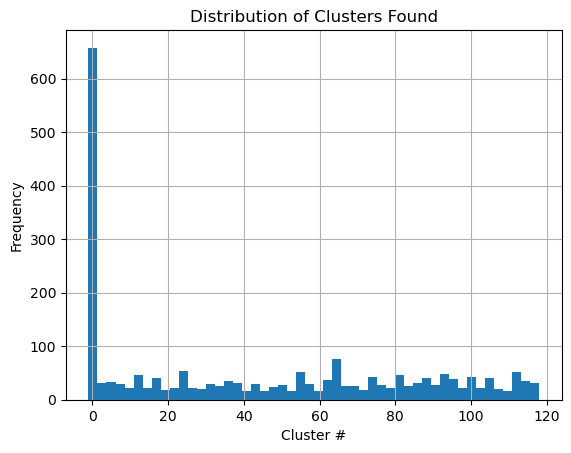

In [14]:
# Clustering distribution
cosine_sim_df.reset_index()['cluster'].hist(bins=50)
plt.title('Distribution of Clusters Found')
plt.xlabel('Cluster #')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Getting number of unrecognised clusters
unrecognized_clust = cosine_sim_df.query('cluster == -1')[['cluster']]\
                            .sort_values('cluster')\
                            .reset_index()

len(unrecognized_clust)

610

In [16]:
# Saving for analysis
cosine_sim_df.reset_index()[['title', 'cluster']].to_csv('../data/entity-clustering/RetA_RetB_clusters.csv')

In [17]:
# Example of the first 20 clusters
query = '0 < cluster < 9' # Clusters from 0 to 9

clusters_df = cosine_sim_df.query(query)[['cluster']]\
                                .sort_values('cluster')\
                                .reset_index()

clusters_0_21 = pd.DataFrame(columns=['title', 'cluster'])
clusters_0_21['title'] = clusters_df['title']
clusters_0_21['cluster'] = clusters_df['cluster']

In [18]:
clusters_0_21

,title,cluster
0,Samsung 22' Black Flat Panel LCD HDTV - LN22A450,1
1,Samsung 46' Series 8 LCD Black Flat Panel HDTV...,1
2,Samsung 52' Series 5 LCD Black Flat Panel HDTV...,1
3,Samsung 46' Series 5 LCD Black Flat Panel HDTV...,1
4,Samsung 58' Black Flat Panel Series 5 Plasma H...,1
...,...,...
125,Samsung PN50A450 50' Plasma TV,8
126,Omnimount 42' - 63' Wishbone Cantilever Extra ...,8
127,15in Lcd/dvd Tv Combo - HLC15R,8
128,"Samsung LN46A850 - 46' 1080P LCD HDTV - 50,000...",8


In [19]:
# Exploring cluster -1
query = 'cluster == -1' # Unrecognized products

clusters_df = cosine_sim_df.query(query)[['cluster']]\
                            .sort_values('cluster')\
                            .reset_index()

clusters_neg_1 = pd.DataFrame(columns=['title', 'cluster'])
clusters_neg_1['title'] = clusters_df['title']
clusters_neg_1['cluster'] = clusters_df['cluster']

In [20]:
len(clusters_neg_1)

610

In [21]:
clusters_neg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    610 non-null    object
 1   cluster  610 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.7+ KB


---

### **AI tool usage for this notebook**

#### ChatGPT 3.5
* Improving markdown annotations and function doctrings

#### ChatGPT 4
* Cluster exploration

```python
query = 'cluster == -1' # Unrecognized products
clusters_df = cosine_sim_df.query(query)[['cluster']]\
                            .sort_values('cluster')\
                            .reset_index()
```

* Help in defining hyperparameter space for the tfidf vectorizer
* Help in repository structure